# Home Credit Default Risk — Preprocessing

**Project:** AI-Powered Intelligent Risk Management System  
**Dataset:** [Kaggle - Home Credit Default Risk](https://www.kaggle.com/competitions/home-credit-default-risk)  
**Input:** `data/train_featured.parquet` (307,511 × 212) | `data/test_featured.parquet` (48,744 × 211)  
**Objective:** Validate full-data statistics, handle missing values, encode categoricals, remove multicollinearity, and prepare the final model-ready dataset.

---

## Table of Contents
1. [Libraries & Configuration](#1)
2. [Data Loading](#2)
3. [Full-Data Validation (EDA Sanity Check)](#3)
4. [Missing Value Strategy](#4)
5. [Outlier Handling](#5)
6. [Categorical Encoding](#6)
7. [Multicollinearity Check](#7)
8. [Final Dataset & Export](#8)

<a id='1'></a>
## 1. Libraries & Configuration

In [36]:
import sys
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Add project root to path for local imports
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

# Paths
DATA_DIR = os.path.join(PROJECT_ROOT, 'data')
PLOT_DIR = os.path.join(PROJECT_ROOT, 'notebooks', 'plots')
os.makedirs(PLOT_DIR, exist_ok=True)

# Display settings
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.4f}'.format)

# Plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print(f"Data directory : {DATA_DIR}")
print(f"Plot directory : {PLOT_DIR}")

Data directory : c:\Users\busra\Projects\Ai_Credit_Risk\data
Plot directory : c:\Users\busra\Projects\Ai_Credit_Risk\notebooks\plots


<a id='2'></a>
## 2. Data Loading

Feature Engineering pipeline çıktısı olan parquet dosyalarını yüklüyoruz.  
Train: 307,511 × 212 | Test: 48,744 × 211 (TARGET sütunu yok).

In [37]:
train = pd.read_parquet(os.path.join(DATA_DIR, 'train_featured.parquet'))
test  = pd.read_parquet(os.path.join(DATA_DIR, 'test_featured.parquet'))

print(f"Train shape: {train.shape}")
print(f"Test  shape: {test.shape}")
print(f"\nTrain memory: {train.memory_usage(deep=True).sum() / 1e6:.1f} MB")
print(f"Test  memory: {test.memory_usage(deep=True).sum() / 1e6:.1f} MB")

Train shape: (307511, 212)
Test  shape: (48744, 211)

Train memory: 499.8 MB
Test  memory: 79.2 MB


<a id='3'></a>
## 3. Full-Data Validation (EDA Sanity Check)

EDA %20 örneklem üzerinde yapılmıştı. Şimdi tam veri üzerinde temel bulguları doğruluyoruz:  
- Sınıf dağılımı (TARGET oranı)  
- Eksik değer haritası  
- Sayısal dağılım istatistikleri (aykırı değer tespiti)  
- Kategorik sütun dağılımları

### 3.1 — Target Distribution (Sınıf Dengesi)

TARGET DISTRIBUTION (Full Data)
  TARGET=0: 282,686 (91.93%)
  TARGET=1:  24,825 (8.07%)
  Ratio: 1:11.4
  Total: 307,511


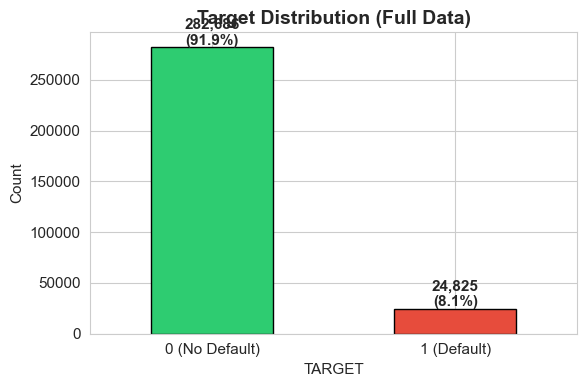

In [38]:
# Sınıf dağılımı — EDA'da %20 örneklemde ~%8 default bulunmuştu
target_counts = train['TARGET'].value_counts()
target_pct    = train['TARGET'].value_counts(normalize=True) * 100

print("=" * 50)
print("TARGET DISTRIBUTION (Full Data)")
print("=" * 50)
for val in [0, 1]:
    print(f"  TARGET={val}: {target_counts[val]:>7,} ({target_pct[val]:.2f}%)")
print(f"  Ratio: 1:{target_counts[0] / target_counts[1]:.1f}")
print(f"  Total: {len(train):,}")
print("=" * 50)

# Visualization
fig, ax = plt.subplots(figsize=(6, 4))
colors = ['#2ecc71', '#e74c3c']
target_counts.plot(kind='bar', color=colors, edgecolor='black', ax=ax)
ax.set_title('Target Distribution (Full Data)', fontsize=14, fontweight='bold')
ax.set_xlabel('TARGET')
ax.set_ylabel('Count')
ax.set_xticklabels(['0 (No Default)', '1 (Default)'], rotation=0)
for i, (count, pct) in enumerate(zip(target_counts, target_pct)):
    ax.text(i, count + 2000, f'{count:,}\n({pct:.1f}%)', ha='center', fontweight='bold')
plt.tight_layout()
plt.show()

### 3.2 — Missing Value Map (Eksik Değer Haritası)

In [39]:
# Eksik değer analizi — tam veri üzerinde
missing = train.isnull().sum()
missing_pct = (missing / len(train)) * 100
missing_df = pd.DataFrame({
    'missing_count': missing,
    'missing_pct': missing_pct
}).query('missing_count > 0').sort_values('missing_pct', ascending=False)

print(f"Total columns with missing values: {len(missing_df)} / {train.shape[1]}")
print(f"Columns with >50% missing: {(missing_df['missing_pct'] > 50).sum()}")
print(f"Columns with 20-50% missing: {((missing_df['missing_pct'] > 20) & (missing_df['missing_pct'] <= 50)).sum()}")
print(f"Columns with <20% missing: {(missing_df['missing_pct'] <= 20).sum()}")
print()

# Kategoriye göre grupla
print("=" * 70)
print("COLUMNS WITH >50% MISSING (drop candidates)")
print("=" * 70)
high_missing = missing_df[missing_df['missing_pct'] > 50]
if len(high_missing) > 0:
    for col, row in high_missing.iterrows():
        print(f"  {col:<45} {row['missing_pct']:>6.1f}%  ({row['missing_count']:>7,.0f})")
else:
    print("  None")

print()
print("=" * 70)
print("COLUMNS WITH 20-50% MISSING")
print("=" * 70)
mid_missing = missing_df[(missing_df['missing_pct'] > 20) & (missing_df['missing_pct'] <= 50)]
if len(mid_missing) > 0:
    for col, row in mid_missing.iterrows():
        print(f"  {col:<45} {row['missing_pct']:>6.1f}%  ({row['missing_count']:>7,.0f})")
else:
    print("  None")

print()
print("=" * 70)
print("COLUMNS WITH <20% MISSING")
print("=" * 70)
low_missing = missing_df[missing_df['missing_pct'] <= 20]
if len(low_missing) > 0:
    for col, row in low_missing.iterrows():
        print(f"  {col:<45} {row['missing_pct']:>6.1f}%  ({row['missing_count']:>7,.0f})")
else:
    print("  None")

Total columns with missing values: 112 / 212
Columns with >50% missing: 55
Columns with 20-50% missing: 9
Columns with <20% missing: 48

COLUMNS WITH >50% MISSING (drop candidates)
  CC_PAYMENT_MIN_DIFF                             80.1%  (246,451)
  CC_AMT_PAYMENT_MEAN                             80.1%  (246,451)
  CC_BALANCE_MAX                                  71.7%  (220,606)
  CC_CREDIT_LIMIT_MEAN                            71.7%  (220,606)
  CC_MIN_PAYMENT_MEAN                             71.7%  (220,606)
  CC_SK_DPD_MEAN                                  71.7%  (220,606)
  CC_SK_DPD_MAX                                   71.7%  (220,606)
  CC_SK_DPD_DEF_MAX                               71.7%  (220,606)
  CC_UTILIZATION_MAX                              71.7%  (220,606)
  CC_DRAWINGS_MEAN                                71.7%  (220,606)
  CC_BALANCE_MEAN                                 71.7%  (220,606)
  CC_UTILIZATION_MEAN                             71.7%  (220,606)
  BB_DPD_STATUS

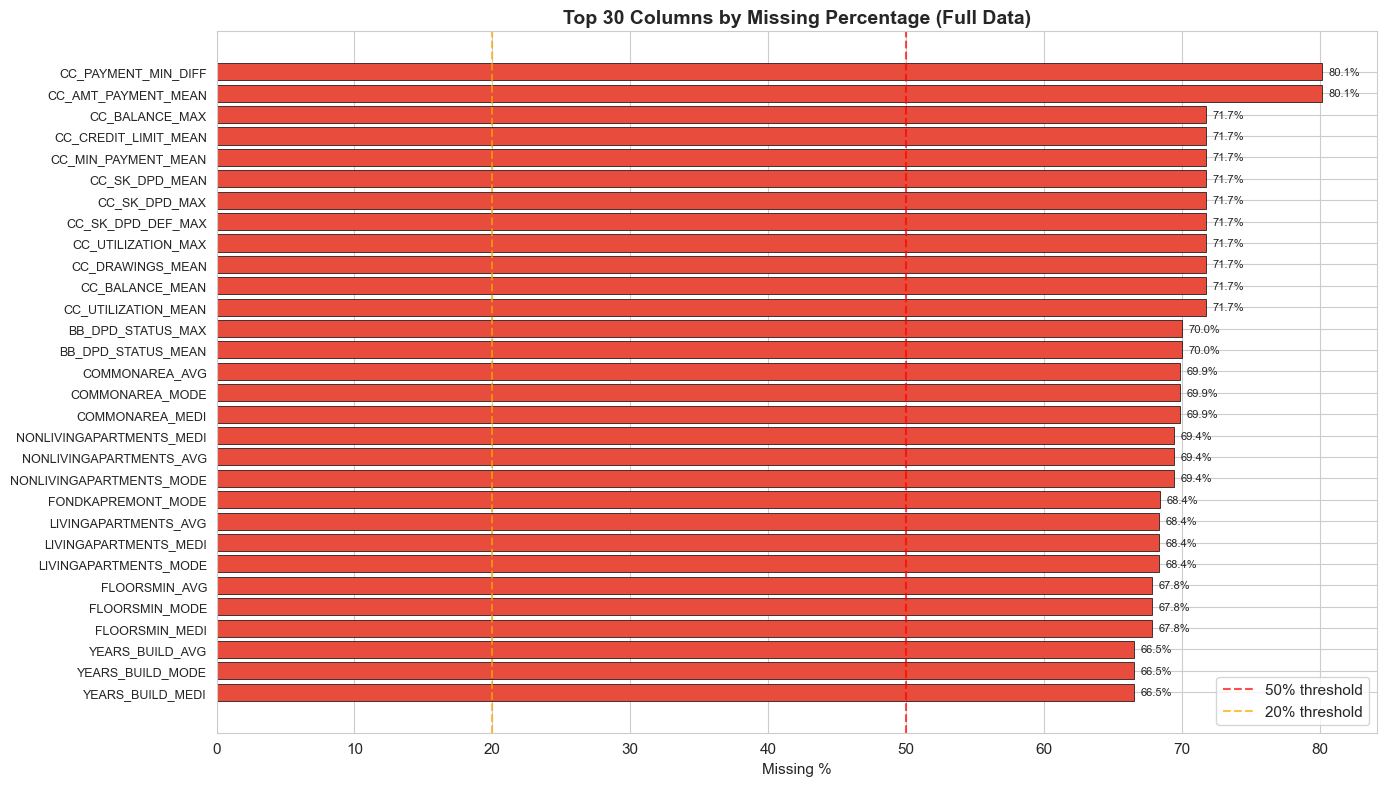

In [40]:
# Missing value heatmap — en çok eksik olan ilk 30 sütun
top_missing = missing_df.head(30)

fig, ax = plt.subplots(figsize=(14, 8))
colors = ['#e74c3c' if pct > 50 else '#f39c12' if pct > 20 else '#3498db'
          for pct in top_missing['missing_pct']]
bars = ax.barh(range(len(top_missing)), top_missing['missing_pct'], color=colors, edgecolor='black', linewidth=0.5)
ax.set_yticks(range(len(top_missing)))
ax.set_yticklabels(top_missing.index, fontsize=9)
ax.set_xlabel('Missing %')
ax.set_title('Top 30 Columns by Missing Percentage (Full Data)', fontsize=14, fontweight='bold')
ax.axvline(x=50, color='red', linestyle='--', alpha=0.7, label='50% threshold')
ax.axvline(x=20, color='orange', linestyle='--', alpha=0.7, label='20% threshold')
ax.legend()
ax.invert_yaxis()

for i, (pct, count) in enumerate(zip(top_missing['missing_pct'], top_missing['missing_count'])):
    ax.text(pct + 0.5, i, f'{pct:.1f}%', va='center', fontsize=8)

plt.tight_layout()
plt.show()

In [41]:
# >%50 eksik olan 55 sütunun detaylı analizi
high_missing = missing_df[missing_df['missing_pct'] > 50].copy()

# Sütun kaynağını belirle (FE prefix'lerine göre)
def get_source(col):
    if col.startswith('CC_'):   return 'Credit Card'
    if col.startswith('BB_'):   return 'Bureau Balance'
    if col.startswith('BUREAU_'): return 'Bureau'
    if col.startswith('PREV_'): return 'Previous App'
    if col.startswith('INST_'): return 'Installments'
    if col.startswith('POS_'):  return 'POS_CASH'
    return 'Application (original)'

high_missing['source'] = high_missing.index.map(get_source)


# TARGET ile korelasyon hesapla (sadece sayısal sütunlarda)
corr_list = []
for col in high_missing.index:
    if train[col].dtype in ['object', 'category']:
        corr_list.append(np.nan)  # kategorik — korelasyon hesaplanamaz
    elif train[col].notna().sum() > 100:
        corr_list.append(train[col].corr(train['TARGET']))
    else:
        corr_list.append(np.nan)

high_missing['target_corr'] = corr_list
# Kaynağa göre grupla
print("=" * 80)
print(f"COLUMNS WITH >50% MISSING: {len(high_missing)} total")
print("=" * 80)

for source, group in high_missing.groupby('source'):
    print(f"\n{'─' * 80}")
    print(f"  SOURCE: {source} ({len(group)} columns)")
    print(f"{'─' * 80}")
    for col, row in group.iterrows():
        corr_str = f"{row['target_corr']:+.4f}" if pd.notna(row['target_corr']) else "  N/A "
        print(f"  {col:<45} {row['missing_pct']:>5.1f}%  corr={corr_str}")

# Özet tablo
print(f"\n{'=' * 80}")
print("SUMMARY BY SOURCE")
print(f"{'=' * 80}")
summary = high_missing.groupby('source').agg(
    count=('missing_pct', 'size'),
    avg_missing=('missing_pct', 'mean'),
    max_abs_corr=('target_corr', lambda x: x.abs().max())
).sort_values('count', ascending=False)
print(summary.to_string())

# Karar önerisi
print(f"\n{'=' * 80}")
print("DECISION HELPER")
print(f"{'=' * 80}")
weak = high_missing[high_missing['target_corr'].abs() < 0.01]
moderate = high_missing[(high_missing['target_corr'].abs() >= 0.01) & (high_missing['target_corr'].abs() < 0.03)]
strong = high_missing[high_missing['target_corr'].abs() >= 0.03]
print(f"  |corr| < 0.01  (DROP candidates):  {len(weak)} columns")
print(f"  |corr| 0.01-0.03 (BORDERLINE):     {len(moderate)} columns")
print(f"  |corr| >= 0.03 (KEEP candidates):   {len(strong)} columns")

COLUMNS WITH >50% MISSING: 55 total

────────────────────────────────────────────────────────────────────────────────
  SOURCE: Application (original) (41 columns)
────────────────────────────────────────────────────────────────────────────────
  COMMONAREA_AVG                                 69.9%  corr=-0.0185
  COMMONAREA_MODE                                69.9%  corr=-0.0163
  COMMONAREA_MEDI                                69.9%  corr=-0.0186
  NONLIVINGAPARTMENTS_MEDI                       69.4%  corr=-0.0028
  NONLIVINGAPARTMENTS_AVG                        69.4%  corr=-0.0032
  NONLIVINGAPARTMENTS_MODE                       69.4%  corr=-0.0016
  FONDKAPREMONT_MODE                             68.4%  corr=  N/A 
  LIVINGAPARTMENTS_AVG                           68.4%  corr=-0.0250
  LIVINGAPARTMENTS_MEDI                          68.4%  corr=-0.0246
  LIVINGAPARTMENTS_MODE                          68.4%  corr=-0.0234
  FLOORSMIN_AVG                                  67.8%  corr=-0.03

### 3.3 — Numerical Distribution Statistics (Aykırı Değer Tespiti)

In [42]:
# Sayısal sütunların istatistikleri — aykırı değer tespiti için
num_cols = train.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c not in ['SK_ID_CURR', 'TARGET']]

print(f"Numerical columns (excluding SK_ID_CURR, TARGET): {len(num_cols)}")
print()

# Persentil tablosu
desc = train[num_cols].describe(percentiles=[.01, .05, .25, .5, .75, .95, .99]).T
desc['iqr'] = desc['75%'] - desc['25%']
desc['range'] = desc['max'] - desc['min']
desc['skew'] = train[num_cols].skew()

# Aşırı çarpık veya aşırı geniş range'e sahip sütunlar
print("=" * 70)
print("HIGHLY SKEWED COLUMNS (|skew| > 5) — log transform candidates")
print("=" * 70)
skewed = desc[desc['skew'].abs() > 5].sort_values('skew', ascending=False)
if len(skewed) > 0:
    print(skewed[['mean', 'std', 'min', '50%', '99%', 'max', 'skew']].to_string())
else:
    print("  None")

print()
print("=" * 70)
print("EXTREME OUTLIER COLUMNS (max > 10x 99th percentile)")
print("=" * 70)
extreme = desc[desc['max'] > desc['99%'] * 10]
if len(extreme) > 0:
    print(extreme[['mean', '99%', 'max', 'skew']].to_string())
else:
    print("  None")

Numerical columns (excluding SK_ID_CURR, TARGET): 194

HIGHLY SKEWED COLUMNS (|skew| > 5) — log transform candidates
                                     mean          std           min         50%           99%             max      skew
INST_PAYMENT_FULFILLMENT           9.7067    4599.6465        0.0000      1.0000        1.5811    2483614.0000  539.7947
INCOME_PER_CHILD              159655.9844  235190.8125     3214.2856 135000.0000   450000.0000  117000000.0000  400.1209
FLAG_DOCUMENT_12                   0.0000       0.0026        0.0000      0.0000        0.0000          1.0000  392.1148
AMT_INCOME_TOTAL              168797.9219  237123.1406    25650.0000 147150.0000   472500.0000  117000000.0000  391.5596
FLAG_DOCUMENT_10                   0.0000       0.0048        0.0000      0.0000        0.0000          1.0000  209.5891
CC_UTILIZATION_MEAN               13.9426    1540.1633      -36.9909      0.1917        1.0349     380993.1562  195.0105
INCOME_PER_FAMILY              93105

### 3.4 — Categorical Column Overview (Kategorik Dağılımlar)

In [43]:
# Kategorik sütunları tespit et
cat_cols = train.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Categorical columns: {len(cat_cols)}")
print()

if len(cat_cols) > 0:
    cat_summary = pd.DataFrame({
        'dtype': train[cat_cols].dtypes,
        'nunique': train[cat_cols].nunique(),
        'missing_pct': (train[cat_cols].isnull().sum() / len(train) * 100).round(2),
        'top_value': [train[c].mode().iloc[0] if not train[c].mode().empty else 'N/A' for c in cat_cols],
        'top_freq_pct': [(train[c].value_counts(normalize=True).iloc[0] * 100).round(1)
                         if train[c].notna().any() else 0 for c in cat_cols]
    }).sort_values('nunique', ascending=False)

    print(cat_summary.to_string())
    print()

    # Çok az kategorili sütunlar (binary veya 3-4 kategorili) — Label Encoding adayları
    print("=" * 70)
    print("BINARY / LOW-CARDINALITY COLUMNS (nunique <= 4) — Label Encoding candidates")
    print("=" * 70)
    low_card = cat_summary[cat_summary['nunique'] <= 4]
    for col in low_card.index:
        vals = train[col].value_counts(dropna=False).head(5)
        print(f"\n  {col} (nunique={low_card.loc[col, 'nunique']}):")
        for v, cnt in vals.items():
            print(f"    {str(v):<30} {cnt:>7,} ({cnt/len(train)*100:.1f}%)")

    print()
    print("=" * 70)
    print("HIGH-CARDINALITY COLUMNS (nunique > 4) — Target/Frequency Encoding candidates")
    print("=" * 70)
    high_card = cat_summary[cat_summary['nunique'] > 4]
    for col in high_card.index:
        print(f"  {col}: {high_card.loc[col, 'nunique']} unique values")
else:
    print("  No categorical columns found (all may have been encoded already).")

Categorical columns: 16

                             dtype  nunique  missing_pct                      top_value  top_freq_pct
ORGANIZATION_TYPE           object       58       0.0000         Business Entity Type 3       22.1000
OCCUPATION_TYPE             object       18      31.3500                       Laborers       26.1000
NAME_INCOME_TYPE            object        8       0.0000                        Working       51.6000
NAME_TYPE_SUITE             object        7       0.4200                  Unaccompanied       81.2000
WALLSMATERIAL_MODE          object        7      50.8400                          Panel       43.7000
WEEKDAY_APPR_PROCESS_START  object        7       0.0000                        TUESDAY       17.5000
NAME_FAMILY_STATUS          object        6       0.0000                        Married       63.9000
NAME_HOUSING_TYPE           object        6       0.0000              House / apartment       88.7000
NAME_EDUCATION_TYPE         object        5       0.0000 

### 3.5 — EDA vs Full Data Comparison Summary

In [44]:
# EDA bulgularıyla karşılaştırma özeti
print("=" * 70)
print("EDA (%20 SAMPLE) vs FULL DATA — COMPARISON")
print("=" * 70)

default_rate = train['TARGET'].mean() * 100
print(f"\n  Default rate:          EDA ~8.0%  |  Full data: {default_rate:.2f}%")

# EXT_SOURCE korelasyonları
for col in ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']:
    if col in train.columns:
        corr = train[col].corr(train['TARGET'])
        print(f"  {col} corr:  EDA ~-0.16  |  Full data: {corr:.4f}")

# Toplam eksik sütun sayısı
n_missing_cols = (train.isnull().sum() > 0).sum()
n_high_missing = (train.isnull().sum() / len(train) > 0.50).sum()
print(f"\n  Columns with any missing:  {n_missing_cols}")
print(f"  Columns with >50% missing: {n_high_missing}")
print(f"  Total columns:             {train.shape[1]}")
print(f"  Total rows:                {train.shape[0]:,}")

print("\n" + "=" * 70)
print("VALIDATION COMPLETE — Ready for preprocessing.")
print("=" * 70)

EDA (%20 SAMPLE) vs FULL DATA — COMPARISON

  Default rate:          EDA ~8.0%  |  Full data: 8.07%
  EXT_SOURCE_1 corr:  EDA ~-0.16  |  Full data: -0.1553
  EXT_SOURCE_2 corr:  EDA ~-0.16  |  Full data: -0.1605
  EXT_SOURCE_3 corr:  EDA ~-0.16  |  Full data: -0.1789

  Columns with any missing:  112
  Columns with >50% missing: 55
  Total columns:             212
  Total rows:                307,511

VALIDATION COMPLETE — Ready for preprocessing.


---

<a id='4'></a>
## 4. Missing Value Strategy

Onaylanan strateji:

| Grup | Aksiyon | Etkilenen Sütun |
|------|---------|----------------|
| EXT_SOURCE_1 | KORU + median + is_missing flag | 1 |
| NONLIVINGAPARTMENTS (AVG/MODE/MEDI) | SİL | 3 |
| CC corr < 0.01 | SİL | 8 |
| CC corr > 0.03 | KORU (NaN bırak — LightGBM native) | 4 |
| Konut AVG/MODE/MEDI üçlüleri | Sadece AVG tut + is_missing flag, MODE+MEDI sil | ~26 gider |
| BB_DPD sütunları | KORU (NaN bırak) | 2 |
| Kategorik + >%50 missing | SİL (FONDKAPREMONT, WALLSMATERIAL, HOUSETYPE) | 3 |
| OWN_CAR_AGE | KORU (tek sütun, corr=0.037) | 1 |

### 4.1 — Define Drop Lists & Execute Drops

In [45]:
print(f"Shape BEFORE drop: train={train.shape}, test={test.shape}")

# ── 1. Kategorik + >%50 missing → SİL ──
cat_high_missing = ['FONDKAPREMONT_MODE', 'WALLSMATERIAL_MODE', 'HOUSETYPE_MODE']

# ── 2. NONLIVINGAPARTMENTS → SİL (corr < 0.003) ──
nonliving_apt = ['NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAPARTMENTS_MEDI']

# ── 3. CC sütunları corr < 0.01 → SİL ──
cc_weak = [
    'CC_PAYMENT_MIN_DIFF', 'CC_AMT_PAYMENT_MEAN',
    'CC_CREDIT_LIMIT_MEAN', 'CC_SK_DPD_MEAN',
    'CC_SK_DPD_MAX', 'CC_SK_DPD_DEF_MAX',
    'CC_UTILIZATION_MAX', 'CC_UTILIZATION_MEAN',
]

# ── 4. Konut AVG/MODE/MEDI → MODE ve MEDI sil, sadece AVG tut ──
housing_groups = [
    'COMMONAREA', 'LIVINGAPARTMENTS', 'FLOORSMIN', 'YEARS_BUILD',
    'LANDAREA', 'BASEMENTAREA', 'NONLIVINGAREA', 'ELEVATORS',
    'APARTMENTS', 'ENTRANCES', 'LIVINGAREA',
    'FLOORSMAX', 'YEARS_BEGINEXPLUATATION', 'TOTALAREA',
]
housing_drop = []
for grp in housing_groups:
    for suffix in ['_MODE', '_MEDI']:
        col = grp + suffix
        if col in train.columns:
            housing_drop.append(col)

# Birleştir
all_drop = cat_high_missing + nonliving_apt + cc_weak + housing_drop

# Sadece gerçekten var olan sütunları filtrele
all_drop = [c for c in all_drop if c in train.columns]

print(f"\nColumns to drop: {len(all_drop)}")
print(f"  Categorical >50% missing:   {len(cat_high_missing)}")
print(f"  NONLIVINGAPARTMENTS:         {len(nonliving_apt)}")
print(f"  CC weak (corr<0.01):         {len(cc_weak)}")
print(f"  Housing MODE+MEDI:           {len(housing_drop)}")

# Drop
train.drop(columns=all_drop, inplace=True)
test.drop(columns=[c for c in all_drop if c in test.columns], inplace=True)

print(f"\nShape AFTER drop: train={train.shape}, test={test.shape}")
print(f"Dropped {len(all_drop)} columns.")

Shape BEFORE drop: train=(307511, 212), test=(48744, 211)

Columns to drop: 41
  Categorical >50% missing:   3
  NONLIVINGAPARTMENTS:         3
  CC weak (corr<0.01):         8
  Housing MODE+MEDI:           27

Shape AFTER drop: train=(307511, 171), test=(48744, 170)
Dropped 41 columns.


### 4.2 — Missing Flags & Imputation

In [46]:
# ── 1. EXT_SOURCE_1: is_missing flag + median imputation ──
for df in [train, test]:
    df['EXT_SOURCE_1_MISSING'] = df['EXT_SOURCE_1'].isnull().astype(int)

ext1_median = train['EXT_SOURCE_1'].median()
train['EXT_SOURCE_1'].fillna(ext1_median, inplace=True)
test['EXT_SOURCE_1'].fillna(ext1_median, inplace=True)
print(f"EXT_SOURCE_1: median={ext1_median:.4f}, flag added")

# ── 2. Konut AVG sütunları: is_missing flag + median imputation ──
housing_avg_cols = [grp + '_AVG' for grp in housing_groups if grp + '_AVG' in train.columns]

flag_count = 0
for col in housing_avg_cols:
    flag_name = col.replace('_AVG', '_MISSING')
    for df in [train, test]:
        df[flag_name] = df[col].isnull().astype(int)
    median_val = train[col].median()
    train[col].fillna(median_val, inplace=True)
    test[col].fillna(median_val, inplace=True)
    flag_count += 1

print(f"Housing AVG columns: {flag_count} imputed with median + missing flag")

# ── 3. OWN_CAR_AGE: is_missing flag + median ──
for df in [train, test]:
    df['OWN_CAR_AGE_MISSING'] = df['OWN_CAR_AGE'].isnull().astype(int)
own_car_median = train['OWN_CAR_AGE'].median()
train['OWN_CAR_AGE'].fillna(own_car_median, inplace=True)
test['OWN_CAR_AGE'].fillna(own_car_median, inplace=True)
print(f"OWN_CAR_AGE: median={own_car_median:.1f}, flag added")

# ── 4. EXT_SOURCE_2, EXT_SOURCE_3: median imputation ──
for col in ['EXT_SOURCE_2', 'EXT_SOURCE_3']:
    if col in train.columns:
        median_val = train[col].median()
        train[col].fillna(median_val, inplace=True)
        test[col].fillna(median_val, inplace=True)
        print(f"{col}: median={median_val:.4f}")

# ── 5. Count/flag FE sütunlarındaki NaN → 0 ──
# (kaydı olmayan müşteri = 0 kredi, 0 gecikme, vb.)
count_flag_patterns = ['_COUNT', '_SUM', '_RATIO', 'HAS_', '_ANOMALY']
count_flag_cols = []
for col in train.columns:
    if any(pat in col for pat in count_flag_patterns):
        if train[col].isnull().sum() > 0:
            count_flag_cols.append(col)

for col in count_flag_cols:
    train[col].fillna(0, inplace=True)
    if col in test.columns:
        test[col].fillna(0, inplace=True)
print(f"Count/flag columns filled with 0: {len(count_flag_cols)}")

# ── 6. Kalan sayısal NaN → median ──
remaining_num = train.select_dtypes(include=[np.number]).columns
remaining_missing = [c for c in remaining_num if train[c].isnull().sum() > 0 and c != 'TARGET']

for col in remaining_missing:
    median_val = train[col].median()
    train[col].fillna(median_val, inplace=True)
    if col in test.columns:
        test[col].fillna(median_val, inplace=True)
print(f"Remaining numeric columns median-imputed: {len(remaining_missing)}")

# ── 7. Kalan kategorik NaN → mode veya 'missing' ──
remaining_cat = train.select_dtypes(include=['object', 'category']).columns.tolist()
cat_imputed = 0
for col in remaining_cat:
    if train[col].isnull().sum() > 0:
        mode_val = train[col].mode().iloc[0] if not train[col].mode().empty else 'missing'
        train[col].fillna(mode_val, inplace=True)
        if col in test.columns:
            test[col].fillna(mode_val, inplace=True)
        cat_imputed += 1
print(f"Categorical columns mode-imputed: {cat_imputed}")

# ── 8. Doğrulama ──
train_missing = train.isnull().sum().sum()
test_missing = test.isnull().sum().sum()
print(f"\n{'=' * 60}")
print(f"MISSING VALUES AFTER IMPUTATION")
print(f"{'=' * 60}")
print(f"  Train NaN remaining: {train_missing}")
print(f"  Test  NaN remaining: {test_missing}")
print(f"  Train shape: {train.shape}")
print(f"  Test  shape: {test.shape}")
if train_missing == 0 and test_missing == 0:
    print("  STATUS: All missing values handled!")
else:
    # Hangi sütunlarda kaldı?
    still_missing = train.columns[train.isnull().any()].tolist()
    print(f"  Still missing in: {still_missing}")

EXT_SOURCE_1: median=0.5060, flag added
Housing AVG columns: 13 imputed with median + missing flag
OWN_CAR_AGE: median=9.0, flag added
EXT_SOURCE_2: median=0.5660
EXT_SOURCE_3: median=0.5353
Count/flag columns filled with 0: 4
Remaining numeric columns median-imputed: 47
Categorical columns mode-imputed: 3

MISSING VALUES AFTER IMPUTATION
  Train NaN remaining: 0
  Test  NaN remaining: 0
  Train shape: (307511, 186)
  Test  shape: (48744, 185)
  STATUS: All missing values handled!


<a id='5'></a>
## 5. Outlier Handling

Aşırı çarpık (skewed) sütunları tespit edip winsorize (%1-%99 clip) uyguluyoruz.  
Ayrıca FE ratio sütunlarında inf/sonsuz değer kontrolü yapıyoruz.

### 5.1 — Inf/NaN Check & Skewness Analysis

In [47]:
# ── 1. Inf değer kontrolü ve temizliği ──
num_cols = train.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c not in ['SK_ID_CURR', 'TARGET']]

inf_counts = {}
for col in num_cols:
    n_inf = np.isinf(train[col]).sum()
    if n_inf > 0:
        inf_counts[col] = n_inf

if inf_counts:
    print(f"Columns with inf values: {len(inf_counts)}")
    for col, cnt in inf_counts.items():
        print(f"  {col}: {cnt} inf values")
    # inf → NaN → median
    for df in [train, test]:
        df.replace([np.inf, -np.inf], np.nan, inplace=True)
    for col in inf_counts:
        median_val = train[col].median()
        train[col].fillna(median_val, inplace=True)
        if col in test.columns:
            test[col].fillna(median_val, inplace=True)
    print("  → Replaced inf with median.")
else:
    print("No inf values found.")

# ── 2. Skewness analizi ──
skewness = train[num_cols].skew().sort_values(ascending=False)
highly_skewed = skewness[skewness.abs() > 5]

print(f"\n{'=' * 70}")
print(f"SKEWNESS ANALYSIS")
print(f"{'=' * 70}")
print(f"Total numeric columns: {len(num_cols)}")
print(f"Highly skewed (|skew| > 5): {len(highly_skewed)}")
print(f"Moderately skewed (2 < |skew| <= 5): {((skewness.abs() > 2) & (skewness.abs() <= 5)).sum()}")

if len(highly_skewed) > 0:
    print(f"\nHighly skewed columns:")
    for col, skew_val in highly_skewed.items():
        print(f"  {col:<45} skew={skew_val:>10.2f}  min={train[col].min():>12.1f}  max={train[col].max():>12.1f}")

No inf values found.

SKEWNESS ANALYSIS
Total numeric columns: 171
Highly skewed (|skew| > 5): 70
Moderately skewed (2 < |skew| <= 5): 36

Highly skewed columns:
  INST_PAYMENT_FULFILLMENT                      skew=    554.29  min=         0.0  max=   2483614.0
  INCOME_PER_CHILD                              skew=    400.12  min=      3214.3  max= 117000000.0
  FLAG_DOCUMENT_12                              skew=    392.11  min=         0.0  max=         1.0
  AMT_INCOME_TOTAL                              skew=    391.56  min=     25650.0  max= 117000000.0
  FLAG_DOCUMENT_10                              skew=    209.59  min=         0.0  max=         1.0
  INCOME_PER_FAMILY                             skew=    187.37  min=      2812.5  max=  39000000.0
  BUREAU_OVERDUE_CREDIT_SUM                     skew=    164.83  min=         0.0  max=   3756681.0
  FLAG_DOCUMENT_2                               skew=    153.79  min=         0.0  max=         1.0
  AMT_REQ_CREDIT_BUREAU_QRT           

### 5.2 — Winsorize (Clip %1-%99)

In [48]:
# Winsorize: sayısal sütunları %1-%99 aralığına clip'le
# FLAG_* sütunları binary olduğu için clip dışı bırakılır
# Tree-based modeller için güvenli bir yaklaşım (sıralama korunur)

# ── FLAG sütunlarını ayır (clip YAPMA) ──
flag_cols = [c for c in num_cols if c.startswith('FLAG_')]
clip_candidates = [c for c in num_cols if not c.startswith('FLAG_')]
print(f"FLAG_* sütunları (clip dışı): {len(flag_cols)}")
print(f"Clip uygulanacak sütunlar:    {len(clip_candidates)}")

clip_count = 0
clip_report = []

for col in clip_candidates:
    if col not in train.columns:
        continue
    p01 = train[col].quantile(0.01)
    p99 = train[col].quantile(0.99)
    
    # Sadece gerçekten uç değer varsa clip yap
    n_below = (train[col] < p01).sum()
    n_above = (train[col] > p99).sum()
    
    if n_below > 0 or n_above > 0:
        before_min, before_max = train[col].min(), train[col].max()
        train[col] = train[col].clip(lower=p01, upper=p99)
        if col in test.columns:
            test[col] = test[col].clip(lower=p01, upper=p99)
        clip_count += 1
        
        # Sadece büyük değişim olan sütunları raporla
        if abs(before_max) > abs(p99) * 3 or abs(before_min) > abs(p01) * 3:
            clip_report.append({
                'column': col,
                'before_min': before_min,
                'before_max': before_max,
                'after_min': p01,
                'after_max': p99,
            })

print(f"\nColumns clipped (%1-%99): {clip_count}")
print(f"Columns with significant outlier reduction: {len(clip_report)}")

if clip_report:
    print(f"\n{'=' * 80}")
    print("SIGNIFICANT CLIPPING (before_max > 3x p99)")
    print(f"{'=' * 80}")
    for r in clip_report[:20]:
        print(f"  {r['column']:<40} [{r['before_min']:>12.1f}, {r['before_max']:>12.1f}] → [{r['after_min']:>12.1f}, {r['after_max']:>12.1f}]")

# ── RATIO sütunlarında negatif min kontrolü ──
ratio_cols = [c for c in num_cols if '_RATIO' in c and c in train.columns]
print(f"\n{'=' * 80}")
print(f"RATIO COLUMNS WITH NEGATIVE MIN ({len(ratio_cols)} ratio cols total)")
print(f"{'=' * 80}")
neg_ratio_found = False
for col in ratio_cols:
    col_min = train[col].min()
    if col_min < 0:
        neg_ratio_found = True
        neg_count = (train[col] < 0).sum()
        neg_pct = neg_count / len(train) * 100
        print(f"  {col:<40} min={col_min:>12.4f}  neg_count={neg_count:>6}  ({neg_pct:.2f}%)")
if not neg_ratio_found:
    print("  No ratio columns with negative min values.")

# Skewness sonrası kontrol
skew_after = train[num_cols].skew()
still_skewed = skew_after[skew_after.abs() > 5]
print(f"\nStill highly skewed after clipping: {len(still_skewed)} (was {len(highly_skewed)})")

# Hâlâ highly skewed olan sütunları listele (FLAG hariç)
still_skewed_no_flag = still_skewed[[c for c in still_skewed.index if not c.startswith('FLAG_')]]
print(f"Still highly skewed (FLAG hariç): {len(still_skewed_no_flag)}")
if len(still_skewed_no_flag) > 0:
    for col, skew_val in still_skewed_no_flag.items():
        print(f"  {col:<45} skew={skew_val:>10.2f}")

FLAG_* sütunları (clip dışı): 26
Clip uygulanacak sütunlar:    145

Columns clipped (%1-%99): 113
Columns with significant outlier reduction: 67

SIGNIFICANT CLIPPING (before_max > 3x p99)
  CNT_CHILDREN                             [         0.0,         19.0] → [         0.0,          3.0]
  AMT_INCOME_TOTAL                         [     25650.0,  117000000.0] → [     45000.0,     472500.0]
  AMT_ANNUITY                              [      1615.5,     258025.5] → [      6183.0,      70006.5]
  CNT_FAM_MEMBERS                          [         1.0,         20.0] → [         1.0,          5.0]
  BASEMENTAREA_AVG                         [         0.0,          1.0] → [         0.0,          0.3]
  COMMONAREA_AVG                           [         0.0,          1.0] → [         0.0,          0.2]
  LANDAREA_AVG                             [         0.0,          1.0] → [         0.0,          0.3]
  LIVINGAPARTMENTS_AVG                     [         0.0,          1.0] → [         0.0,  

19 çocuk / 20 aile üyesi gerçek hayatta aşırı nadir

%99 üstü zaten “uç” kabul edilebilir

117 milyon gelir = dataset’i patlatan birkaç kayıt

%99 quantile ≈ 470k → gayet makul

1.0 = %100 alan → aşırı nadir

%99’da 0.2–0.3 olması çok normal



<a id='6'></a>
## 6. Categorical Encoding

Binary/low-cardinality (nunique <= 4) sütunlara Label Encoding,  
high-cardinality (nunique > 4) sütunlara Frequency Encoding uyguluyoruz.  
Train'de fit, her iki sete de transform.

In [49]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# ─────────────────────────────────────────────
# 1. Categorical columns tespiti
# ─────────────────────────────────────────────
cat_cols = train.select_dtypes(include=["object", "category"]).columns.tolist()
print(f"Categorical columns found: {len(cat_cols)}")

if len(cat_cols) == 0:
    print("No categorical columns to encode.")

else:
    # Kardinaliteye göre ayır
    low_card = [c for c in cat_cols if train[c].nunique(dropna=True) <= 4]
    high_card = [c for c in cat_cols if train[c].nunique(dropna=True) > 4]

    print(f"  Low cardinality (≤4): {len(low_card)} → Label Encoding")
    print(f"  High cardinality (>4): {len(high_card)} → Frequency Encoding")

    # ─────────────────────────────────────────
    # 2. LABEL ENCODING (low-cardinality)
    # ─────────────────────────────────────────
    le_report = []

    for col in low_card:
        le = LabelEncoder()

        # Sadece TRAIN ile fit et (leakage yok)
        le.fit(train[col].dropna())

        # Train transform
        train[col] = train[col].map(
            lambda x: le.transform([x])[0] if pd.notna(x) else -1
        )

        # Test transform (unseen → -1)
        test[col] = test[col].map(
            lambda x: le.transform([x])[0] if (pd.notna(x) and x in le.classes_) else -1
        )

        le_report.append((col, len(le.classes_), list(le.classes_)))

    # Rapor
    if le_report:
        print("\n" + "=" * 70)
        print("LABEL ENCODED COLUMNS")
        print("=" * 70)
        for col, n_cls, classes in le_report:
            print(f"  {col:<40} {n_cls} classes: {classes}")

    # ─────────────────────────────────────────
    # 3. FREQUENCY ENCODING (high-cardinality)
    # ─────────────────────────────────────────
    freq_report = []

    for col in high_card:
        # Missing flag (önemli sinyal!)
        train[f"{col}_MISSING"] = train[col].isna().astype(int)
        test[f"{col}_MISSING"] = test[col].isna().astype(int)

        # Train frekansları
        freq_map = (
            train[col]
            .value_counts(normalize=True, dropna=True)
            .to_dict()
        )

        # Map
        train[col] = train[col].map(freq_map)
        test[col] = test[col].map(freq_map).fillna(0)

        freq_report.append((col, len(freq_map)))

    # Rapor
    if freq_report:
        print("\n" + "=" * 70)
        print("FREQUENCY ENCODED COLUMNS")
        print("=" * 70)
        for col, n_cats in freq_report:
            print(f"  {col:<40} {n_cats} categories → frequency values")

    # ─────────────────────────────────────────
    # 4. Final kontrol
    # ─────────────────────────────────────────
    remaining_cat = train.select_dtypes(include=["object", "category"]).columns.tolist()
    print(f"\nCategorical columns remaining after encoding: {len(remaining_cat)}")

    if remaining_cat:
        print(f"WARNING — still categorical: {remaining_cat}")
    else:
        print("All categorical features encoded successfully ✅")


Categorical columns found: 13
  Low cardinality (≤4): 5 → Label Encoding
  High cardinality (>4): 8 → Frequency Encoding

LABEL ENCODED COLUMNS
  NAME_CONTRACT_TYPE                       2 classes: ['Cash loans', 'Revolving loans']
  CODE_GENDER                              3 classes: ['F', 'M', 'XNA']
  FLAG_OWN_CAR                             2 classes: ['N', 'Y']
  FLAG_OWN_REALTY                          2 classes: ['N', 'Y']
  EMERGENCYSTATE_MODE                      2 classes: ['No', 'Yes']

FREQUENCY ENCODED COLUMNS
  NAME_TYPE_SUITE                          7 categories → frequency values
  NAME_INCOME_TYPE                         8 categories → frequency values
  NAME_EDUCATION_TYPE                      5 categories → frequency values
  NAME_FAMILY_STATUS                       6 categories → frequency values
  NAME_HOUSING_TYPE                        6 categories → frequency values
  OCCUPATION_TYPE                          18 categories → frequency values
  WEEKDAY_APPR_PROCE

<a id='7'></a>
## 7. Multicollinearity Check

|corr| > 0.95 olan sütun çiftlerini buluyoruz. Her çiftten TARGET ile daha düşük korelasyona sahip olanı siliyoruz.

In [51]:
# Korelasyon matrisi hesapla (sadece sayısal sütunlar)
num_cols_now = train.select_dtypes(include=[np.number]).columns.tolist()
num_cols_now = [c for c in num_cols_now if c not in ['SK_ID_CURR', 'TARGET']]

print(f"Computing correlation matrix for {len(num_cols_now)} numeric columns...")
corr_matrix = train[num_cols_now].corr().abs()

# Üst üçgeni al (kendisiyle ve tekrar eden çiftleri atla)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# |corr| > 0.95 olan çiftleri bul
high_corr_pairs = []
for col in upper.columns:
    correlated = upper.index[upper[col] > 0.95].tolist()
    for corr_col in correlated:
        high_corr_pairs.append((col, corr_col, corr_matrix.loc[col, corr_col]))

print(f"Highly correlated pairs (|corr| > 0.95): {len(high_corr_pairs)}")

# Her çiftten TARGET ile daha az ilişkili olanı sil
target_corr = train[num_cols_now].corrwith(train['TARGET']).abs()

to_drop_multi = set()
print(f"\n{'=' * 80}")
print("MULTICOLLINEARITY — PAIRS & DECISIONS")
print(f"{'=' * 80}")

for col1, col2, corr_val in sorted(high_corr_pairs, key=lambda x: -x[2]):
    tc1 = target_corr.get(col1, 0)
    tc2 = target_corr.get(col2, 0)
    drop = col2 if tc1 >= tc2 else col1
    keep = col1 if drop == col2 else col2
    to_drop_multi.add(drop)
    print(f"  {col1:<35} vs {col2:<35} corr={corr_val:.4f} → DROP {drop} (|target_corr|={target_corr.get(drop, 0):.4f})")

print(f"\nColumns to drop: {len(to_drop_multi)}")

if to_drop_multi:
    train.drop(columns=list(to_drop_multi), inplace=True)
    test.drop(columns=[c for c in to_drop_multi if c in test.columns], inplace=True)
    print(f"Shape after multicollinearity removal: train={train.shape}, test={test.shape}")
else:
    print("No columns removed.")

Computing correlation matrix for 192 numeric columns...
Highly correlated pairs (|corr| > 0.95): 30

MULTICOLLINEARITY — PAIRS & DECISIONS
  OWN_CAR_AGE_MISSING                 vs HAS_CAR                             corr=1.0000 → DROP HAS_CAR (|target_corr|=0.0218)
  AGE_YEARS                           vs DAYS_BIRTH                          corr=1.0000 → DROP AGE_YEARS (|target_corr|=0.0782)
  REGISTRATION_YEARS                  vs DAYS_REGISTRATION                   corr=1.0000 → DROP REGISTRATION_YEARS (|target_corr|=0.0419)
  EMPLOYED_YEARS                      vs DAYS_EMPLOYED                       corr=1.0000 → DROP EMPLOYED_YEARS (|target_corr|=0.0640)
  OWN_CAR_AGE_MISSING                 vs FLAG_OWN_CAR                        corr=1.0000 → DROP OWN_CAR_AGE_MISSING (|target_corr|=0.0218)
  HAS_CAR                             vs FLAG_OWN_CAR                        corr=1.0000 → DROP HAS_CAR (|target_corr|=0.0218)
  DAYS_EMPLOYED_ANOMALY               vs FLAG_EMP_PHONE            

<a id='8'></a>
## 8. Final Dataset & Export

In [52]:
# ── Final validation ──
print("=" * 70)
print("FINAL DATASET SUMMARY")
print("=" * 70)

print(f"\n  {'Metric':<35} {'Train':>15} {'Test':>15}")
print(f"  {'-'*35} {'-'*15} {'-'*15}")
print(f"  {'Rows':<35} {train.shape[0]:>15,} {test.shape[0]:>15,}")
print(f"  {'Columns':<35} {train.shape[1]:>15} {test.shape[1]:>15}")
print(f"  {'Numeric columns':<35} {train.select_dtypes(include=[np.number]).shape[1]:>15} {test.select_dtypes(include=[np.number]).shape[1]:>15}")
print(f"  {'Categorical columns':<35} {train.select_dtypes(include=['object','category']).shape[1]:>15} {test.select_dtypes(include=['object','category']).shape[1]:>15}")
print(f"  {'Missing values':<35} {train.isnull().sum().sum():>15} {test.isnull().sum().sum():>15}")
print(f"  {'Memory (MB)':<35} {train.memory_usage(deep=True).sum()/1e6:>15.1f} {test.memory_usage(deep=True).sum()/1e6:>15.1f}")

# Başlangıç vs son karşılaştırma
print(f"\n  {'='*65}")
print(f"  BEFORE → AFTER")
print(f"  {'='*65}")
print(f"  Columns: 212 → {train.shape[1]} (dropped {212 - train.shape[1]})")
print(f"  New flag columns added: EXT_SOURCE_1_MISSING, OWN_CAR_AGE_MISSING, housing _MISSING flags")

FINAL DATASET SUMMARY

  Metric                                        Train            Test
  ----------------------------------- --------------- ---------------
  Rows                                        307,511          48,744
  Columns                                         169             168
  Numeric columns                                 169             168
  Categorical columns                               0               0
  Missing values                                    0               0
  Memory (MB)                                   241.1            38.0

  BEFORE → AFTER
  Columns: 212 → 169 (dropped 43)
  New flag columns added: EXT_SOURCE_1_MISSING, OWN_CAR_AGE_MISSING, housing _MISSING flags


### 8.1 — Export to Parquet

In [53]:
# Diske kaydet
train_path = os.path.join(DATA_DIR, 'train_processed.parquet')
test_path  = os.path.join(DATA_DIR, 'test_processed.parquet')

train.to_parquet(train_path, index=False)
test.to_parquet(test_path, index=False)

train_size = os.path.getsize(train_path) / 1e6
test_size  = os.path.getsize(test_path) / 1e6

print("=" * 70)
print("EXPORT COMPLETE")
print("=" * 70)
print(f"  {train_path}")
print(f"    → {train.shape[0]:,} rows × {train.shape[1]} cols ({train_size:.1f} MB)")
print(f"  {test_path}")
print(f"    → {test.shape[0]:,} rows × {test.shape[1]} cols ({test_size:.1f} MB)")
print(f"\nReady for modeling (next notebook: 04_modeling.ipynb)")

EXPORT COMPLETE
  c:\Users\busra\Projects\Ai_Credit_Risk\data\train_processed.parquet
    → 307,511 rows × 169 cols (54.7 MB)
  c:\Users\busra\Projects\Ai_Credit_Risk\data\test_processed.parquet
    → 48,744 rows × 168 cols (10.1 MB)

Ready for modeling (next notebook: 04_modeling.ipynb)
